In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import model_selection, preprocessing
import seaborn as sns

In [2]:
data_variant = pd.read_csv("./training/training_variants")
data_txt = pd.read_csv("./training/training_text", sep='\|\|', names=["ID","TEXT"], skiprows=1, engine='python')

In [3]:
data_variant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [4]:
data_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [5]:
data_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


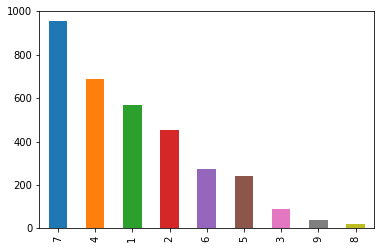

In [6]:
variants = data_variant['Class'].value_counts()

variants.plot.bar()

([<matplotlib.axis.YTick at 0x1a2994479e8>,
 <a list of 9 Text yticklabel objects>)

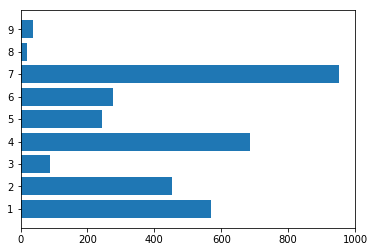

In [7]:
plt.barh(variants.index, variants.values)
plt.yticks(variants.index)

In [8]:
data_txt.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
data_variant.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


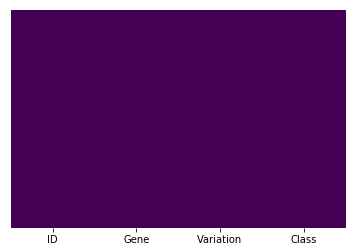

In [10]:
sns.heatmap(data_variant.isnull(),cbar=False, yticklabels=False,cmap='viridis')

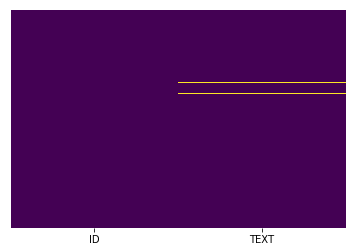

In [11]:
sns.heatmap(data_txt.isnull(),cbar=False, yticklabels=False,cmap='viridis')

In [12]:
data_txt[data_txt.isnull().any(axis=1)].count()

ID      5
TEXT    0
dtype: int64

ML Problem statement :
1. We have to predict the cancer class (1-9) based on the type of mutation a person has. Its a multiclass classification problem.
2. Errors are very bad in medical world and it is better for doctors to provide reasoning why a person falls under one of 9 categories of cancer. 
    a) Talking in probabilistic term will be more intutive here
    b) Interpretability of results (why perticular class) is also necessary
3. As we are more focussed towards accuracy , we can allow some expensive operations/algorithms to do calculation inorder to achive desired accuracy.

In [13]:
# from data_txt, we would like to process research papers, that is text field
# we want to remove stop words, using nltk 
from nltk.corpus import stopwords
import re

In [14]:
def data_txt_preprocess(text, ind, col):
    # remove integers from text
    if type(text) is not int:
        string = ''
        
        # replacing all special characters with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', str(text))
        
        # replace multiple spaces with single space
        text = re.sub('\s+',' ', str(text))
        
        text = text.lower()
        stop_words = set(stopwords.words('english')) 
        for word in text.split():
            if word not in stop_words:
                string+=word + " "
                
        data_txt.loc[ind, col] = string

In [15]:
# call the above function and preprocess all the text data
for index, row in data_txt.iterrows():
    if type(row['TEXT']) is str:
        data_txt_preprocess(row['TEXT'], index,'TEXT')

data_txt.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [16]:
# merge two data
result = pd.merge(data_variant, data_txt, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [17]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [18]:
# impudate TEXT field with gene and variation name
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + " " + result['Variation'] 

In [19]:
# check for null values again.
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


# Create train, test and validation set

In [20]:
# Before splitting , lets remove all spaces in Gene and Variations columns
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

In [21]:
X = result.drop('Class', axis=1)
y = result['Class']
X.head()

,ID,Gene,Variation,TEXT
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,abstract background non small cell lung cancer...
2,2,CBL,Q249E,abstract background non small cell lung cancer...
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print("Train size: ", len(y_train))
print("Cross validation size: ", len(y_cv))
print("Test data size: ", len(y_test))

Train size:  2124
Cross validation size:  532
Test data size:  665


In [23]:
# check if all class examples are properly distributed in all three train , CV and test parts, otherwise it will be a problem
train_class_distribution = y_train.value_counts()
validation_class_distribution = y_cv.value_counts()
test_class_distribution = y_test.value_counts()

print(train_class_distribution)

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64


In [24]:
y_train.value_counts().loc[2]

289

In [25]:
# calculate %age class distribution in each data set
percent_dict = {}
for i in range(1,10):
    train_dist = np.round_(100*y_train.value_counts().loc[i]/y.value_counts().loc[i])
    test_dist = np.round_(100*y_test.value_counts().loc[i]/y.value_counts().loc[i])
    cv_dist = np.round_(100*y_cv.value_counts().loc[i]/y.value_counts().loc[i])
    percent_dict[i] = [train_dist, cv_dist, test_dist]
    
    
percent_dict
    

{1: [64.0, 16.0, 20.0],
 2: [64.0, 16.0, 20.0],
 3: [64.0, 16.0, 20.0],
 4: [64.0, 16.0, 20.0],
 5: [64.0, 16.0, 20.0],
 6: [64.0, 16.0, 20.0],
 7: [64.0, 16.0, 20.0],
 8: [63.0, 16.0, 21.0],
 9: [65.0, 16.0, 19.0]}

In [26]:
percent_df = pd.DataFrame.from_dict(percent_dict, orient='index')
percent_df.columns = ['Train','CV','Test']

percent_df

#fig, ax = plt.subplots(1,3)
#ax[0].bar(percent_df.index, percent_df['Train'])

,Train,CV,Test
1,64.0,16.0,20.0
2,64.0,16.0,20.0
3,64.0,16.0,20.0
4,64.0,16.0,20.0
5,64.0,16.0,20.0
6,64.0,16.0,20.0
7,64.0,16.0,20.0
8,63.0,16.0,21.0
9,65.0,16.0,19.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.


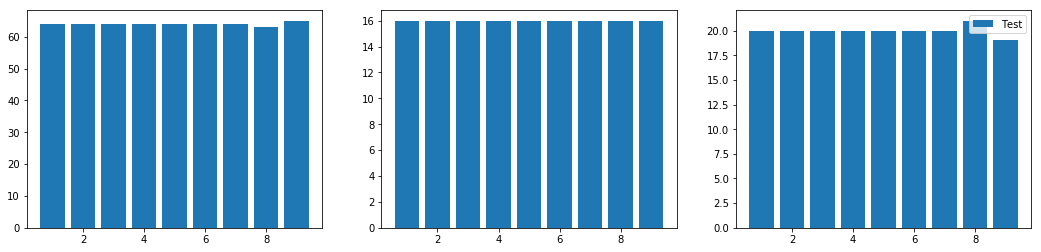

In [27]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(18)
for i in range(0,3):
    ax[i].bar(percent_df.index, percent_df.iloc[:,i], label = percent_df.columns[i])
    plt.legend()


## Building a rondom model (worst model) to set a performance bench mark

### perfomance matrics -  Log loss function, = -1/n * Sum (y*log(p) + (1-y)*log(1-p))

In [28]:
# Generate random probabilities and calculate log loss on CV and Test data set
CV_data_len = X_cv.shape[0]
Test_data_len = X_test.shape[0]
from sklearn.metrics import log_loss

In [48]:
# for cross validattion
cv_predicted_y = np.zeros((CV_data_len,9))
for i in range(CV_data_len):
    rand_prob = np.random.rand(1,9)
    cv_predicted_y[i] = (rand_prob/sum(sum(rand_prob)))[0]
print("CV log loss : ", log_loss(y_cv,cv_predicted_y))

CV log loss :  2.4592234250820577


In [49]:
# for test data set
test_predicted_y = np.zeros((Test_data_len,9))
for i in range(Test_data_len):
    rand_prob = np.random.rand(1,9)
    test_predicted_y[i] = (rand_prob/sum(sum(rand_prob)))[0]
print("Test prediction log loss : ", log_loss(y_test,test_predicted_y))

Test prediction log loss :  2.5379593459662577


In [50]:
worst_predicted = np.argmax(test_predicted_y, axis=1)
worst_predicted

array([2, 5, 2, 5, 3, 3, 8, 6, 7, 2, 8, 7, 8, 1, 7, 0, 6, 5, 1, 4, 6, 0,
       7, 0, 4, 4, 8, 7, 6, 5, 8, 6, 2, 6, 3, 1, 0, 6, 2, 2, 3, 1, 8, 4,
       3, 5, 2, 3, 4, 7, 4, 8, 0, 1, 4, 8, 5, 1, 3, 8, 0, 0, 4, 5, 2, 0,
       8, 3, 2, 6, 8, 4, 8, 5, 3, 6, 0, 0, 7, 6, 2, 8, 8, 0, 0, 0, 0, 5,
       1, 1, 6, 7, 0, 8, 2, 1, 4, 6, 8, 2, 6, 8, 1, 3, 5, 8, 3, 7, 7, 7,
       8, 3, 6, 4, 5, 0, 4, 0, 3, 0, 0, 5, 8, 7, 2, 1, 7, 6, 3, 3, 5, 3,
       1, 3, 0, 8, 6, 1, 5, 4, 3, 1, 5, 3, 3, 2, 5, 6, 4, 1, 6, 0, 2, 7,
       1, 4, 1, 7, 5, 4, 5, 6, 5, 6, 0, 3, 8, 6, 6, 3, 8, 2, 4, 2, 4, 5,
       3, 1, 1, 3, 7, 0, 0, 5, 2, 5, 7, 0, 7, 1, 3, 5, 5, 1, 4, 4, 1, 5,
       8, 7, 3, 6, 5, 3, 8, 1, 5, 5, 7, 1, 5, 3, 5, 4, 8, 4, 8, 7, 4, 7,
       8, 1, 0, 1, 4, 0, 1, 7, 7, 4, 2, 7, 6, 6, 1, 5, 1, 0, 3, 1, 7, 4,
       7, 4, 5, 8, 0, 4, 7, 0, 1, 0, 6, 4, 7, 4, 5, 0, 1, 7, 1, 2, 4, 0,
       3, 7, 5, 0, 3, 1, 5, 1, 5, 8, 5, 4, 4, 0, 2, 1, 8, 5, 2, 4, 4, 7,
       7, 0, 4, 7, 3, 1, 0, 5, 0, 2, 1, 0, 7, 3, 7,

In [51]:
worst_predicted = worst_predicted + 1

In [57]:
# calculate confusion matrix, precision and recall

from sklearn.metrics import confusion_matrix

C = confusion_matrix(y_test, worst_predicted)
C

array([[15, 10,  9, 15, 12, 12, 18, 14,  9],
       [14,  8, 12,  7,  9, 10, 11,  8, 12],
       [ 3,  2,  3,  2,  1,  1,  1,  2,  3],
       [15, 18, 14, 18, 17, 21, 12, 13,  9],
       [ 2,  4,  6,  7,  7,  4,  4,  8,  6],
       [12,  6,  6,  1, 15,  1,  4,  8,  2],
       [23, 14, 20, 24, 21, 29, 17, 20, 23],
       [ 0,  1,  1,  0,  0,  0,  0,  2,  0],
       [ 1,  1,  0,  1,  0,  2,  0,  0,  2]], dtype=int64)

Text(159,0.5,'Actual Classes')

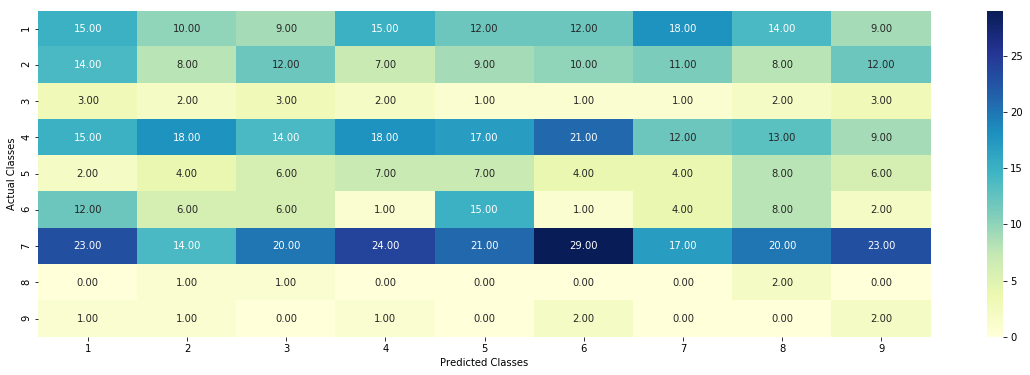

In [56]:
classes = [n for n in range(1,10)]
plt.figure(figsize=(20,6))
sns.heatmap(C, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

In [58]:
# precision metics
# out of all prediction for a perticular class , what portion is correct
P = C/C.sum(axis = 0)

Text(159,0.5,'Actual Classes')

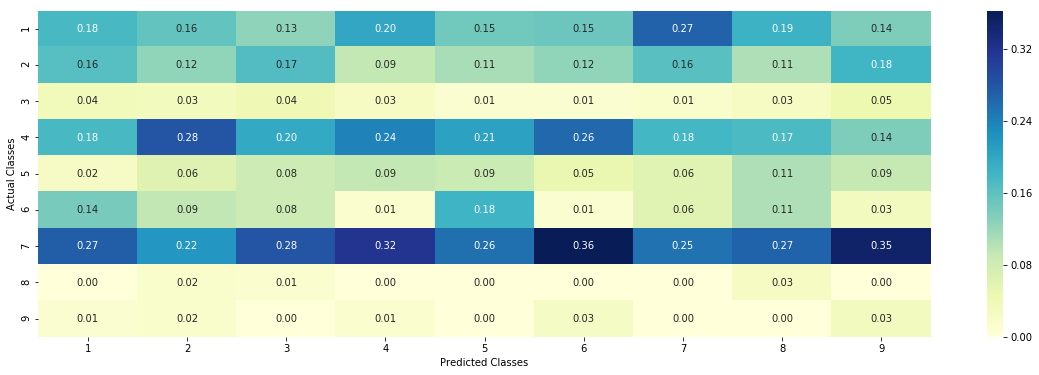

In [59]:

plt.figure(figsize=(20,6))
sns.heatmap(P, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

In [62]:
# Recall
# Out of all those belogs to one class, what portion is predicted correctly
R = (C.T / C.sum(axis=1)).T

Text(159,0.5,'Actual Classes')

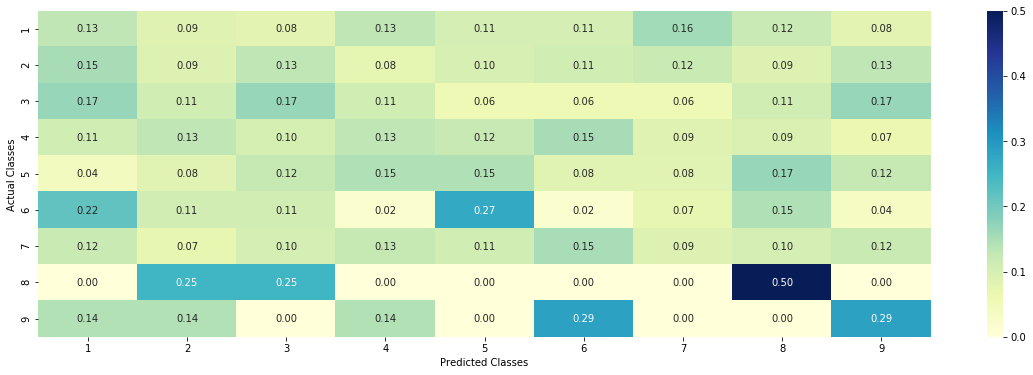

In [63]:

plt.figure(figsize=(20,6))
sns.heatmap(R, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

## Evaluate Gene column

In [69]:
unique_genes = X_train['Gene'].value_counts()
print("count : ", unique_genes.shape[0])
unique_genes.head(10)

count :  236


BRCA1     150
TP53      107
EGFR       95
BRCA2      82
PTEN       76
KIT        71
BRAF       61
ALK        46
ERBB2      41
PDGFRA     39
Name: Gene, dtype: int64

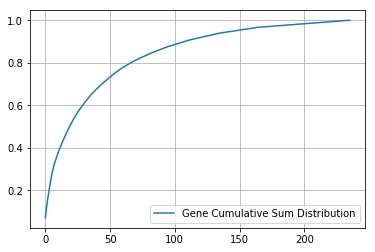

In [72]:
# plot a cumulative graph on gene column to see distribution
# first normalize the counts
s = sum(unique_genes.values)
h = unique_genes.values / s
c_sum = np.cumsum(h)
plt.plot(c_sum, label = "Gene Cumulative Sum Distribution")
plt.grid()
plt.legend()

#### We can see from above graph that more than 75% of data are for top 50 genes
## Lets deal with this categorical data now

### There are two methods -
#### One hot Encoding - 
#### Responce Encoding (Mean Imputation)

There is much more problem with one hot encoding here as unique categories are 236 in this case. Lets see both -

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer = CountVectorizer()

In [76]:
train_gene_feature_onehotencoding = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_onehotencoding = gene_vectorizer.fit_transform(X_cv['Gene'])
test_gene_feature_onehotencoding = gene_vectorizer.fit_transform(X_test['Gene'])

train_gene_feature_onehotencoding.shape

(2124, 236)

In [78]:
gene_vectorizer.get_feature_names()

['abl1',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'atm',
 'b2m',
 'bap1',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'dicer1',
 'egfr',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'errfi1',
 'esr1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fat1',
 'fbxw7',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'flt3',
 'foxa1',
 'foxo1',
 'gata3',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'inpp4b',
 'jak1',
 'jak2',
 'kdm5c',
 'keap1',
 'kit',
 'kmt2a',
 'kmt2c',
 'kmt2d',
 'knstrn',
 'kras',
 'map2k1',
 'map2k2',
 'map2k4',
 'mapk1',
 'mef2b',
 'men1',
 'met',
 'mlh1',
 'mpl',
 'msh2',
 'msh6',
 'mtor',
 'myd88',
 'ncor1',
 'nf1',
 'nf2',
 'nfe2l2',
 'nfkbia',
 'nkx2',
 'notch1',
 'npm1',
 'ntrk1',
 'ntrk2',
 'pak1',
 'pdgfra',
 'pdgfrb',
 'pik3ca',
 'pik3c

One hot encoding will create too many columns and increase dimentionality of dataset. Models like Random forest will not perform better with high dimentional data. However dimentionality is fine for Linear/Logistic Regression and SVM like models.

## Responce Encoding with Laplas smooting

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea